# Monte Carlo Implementation for Easy 21

# Introduction

What is Reinforcement learning? It is learning to perform a task which involves taking suitable actions so as to maximize reward obtained while performing the task. The main idea of reinforcement is that the learner is not told which actions to take but learns by discovering which actions may lead to better rewards by trying them out. The immediate action may not yield the maximum possible return but the goal of learning here is to maximize cumulative returns from the actions taken while performing the task.

There are various possibilities for an environment and a RL agent has to go from being uncertain about the environment, to understanding which set of actions to take to achieve its goal. The agent tries various actions and progressively favors those that appear to be best. It is a stochastic approach where the actions need to be tried many times to obtain a reliable estimate of expected returns. For an optimal behavior it is of utmost importance to understand the trade off between exploration and exploitation. In exploitation the model takes an action which tends to provide maximum returns, while in exploration it tries to assess expected return from other actions.

<img width=60% height=50% src="agentAndEnvironment.png"/>

Links  
Lecture series : http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html  
Assignment : http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf  

A Markov decision process (MDP) describes the environment. It consists of a set of states S, a set of actions A, a reward function R where R(s,a) determines the immediate reward on taking action a in state s (s ε S) which leads to states to s'. If knowledge of prior actions or states affects the current choice of action then the decision process is not Markov.

A Markov reward process is a tuple ( S, P, R, γ) where S is a finite set of states, P is the transition probability matrix where Pss' = P[St+1 = s' | St = s] . R is a reward function where, Rs = E [Rt+1 | St = s] . γ is the discount factor with γ ε [0,1].

As mentioned earlier, policy π is a mapping of states-action which defines the behavior of an agent and is expressed as follows,

π (a|s) = P [ At = a | St = s ]

The main idea of behind a discount factor (γ) is to calculate cumulative rewards from t time steps ahead with their emphasis or influence on current reward diminishing as look ahead t increases. The return Gt can be described best from the following slide:

<img width=60% height=50% src="Return.png"/>

The value function which give the long term expected returns at state s are calculated as,

v (s) = E [Gt | St = s]

On decomposing the value function above into immediate reward R t+1 and discounted values of successor states we get the Bellman equation which is expressed as,

v (s) = E [ Rt+1 +  γ v(St+1) |  St = s]

Now our state-value and action-value functions are defined as follows,

<img width=60% height=50% src="value.png"/>

which decompose into the Bellman expectation equations as,

<img width=60% height=50% src="bellman.png"/>

There is always at least one policy which is better than or equal to all other policies which is called the optimal policy. It can obtained as follows,

<img width=60% height=50% src="optimalPolicy.png"/>

# Objective

To understand the crux of the intuition and start small I chose the assignment Easy 21. Easy 21 is a variant of black jack with the following rules,

* The game is played with an infinite deck i.e cards are sampled with replacement.
* There are no face cards in this game and values of the cards range from 1-10.
* The probability of drawing a red card is 1/3 and that of a black card is 2/3.
* The value of a red is subtracted while that of a black card is added.
* At the start of the game both the player and the dealer draw one black card.
* There are two actions in this game i.e. stick or hit. If the player sticks it receives no further cards
* If the player’s sum exceeds 21, or becomes less than 1, then it “goes bust” and loses the game (reward -1)
* The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer sticks then only the player takes turn until it goes bust or wins, and vice-versa.
* If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In Monte Carlo control evaluation the value we calculate at each step is the empirical mean return and not the expected return. An incremental counter is used to calculate the incremental total return. The incremental Monte Carlo updates as follows,

<img width=60% height=50% src="Monte.png"/>

# Experiment

In this experiment the RL agent will learn how to maximize its returns from Easy 21 by using Monte Carlo incremental updates to its state-action values. The expected outcome from this experiment will be to obtain an optimal state-action matrix. Then this state-action matrix will be visualized to see if the agent has an optimal value function or not. 

In [1]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import json

In [2]:
xk = np.arange(2)
pk = [1/float(3),2/float(3)]
CUSTOM_RANDOMIZE = stats.rv_discrete(values=(xk,pk))
CARD_COLOR = ['red','black']

In [3]:
def deal():
    # 0 is red and 1 is black
    cardColorIndex = CUSTOM_RANDOMIZE.rvs(size=1)
    return cardColorIndex, random.randint(1, 10)

In [4]:
def step(state,action):
    # state[0]- dealer's first card and state[1]- player's sum
    playerSum = state[1]
    dealerSum = state[0]
    
    if action == 0:
        # player action = stick
        #print "stick: ",playerSum
        # dealer plays
        dealerSum = dealerPlaying(state[0])
        if dealerSum >21:
            return [dealerSum,playerSum],1
        elif dealerSum < playerSum:
            return [dealerSum,playerSum],1
        elif dealerSum == playerSum:
            return [dealerSum,playerSum],0
        elif dealerSum > playerSum:
            return [dealerSum,playerSum],-1  
    else:
        # player action = hit
        cardColorIndex, cardNumber = deal()
        #print cardColorIndex,cardNumber
        if cardColorIndex == 0:
            # subtract from sum
            playerSum-= cardNumber
        else:
            # add to sum
            playerSum += cardNumber
            
        if playerSum < 21 and playerSum > 1:
            return [dealerSum,playerSum],0
        else:
            return [dealerSum,playerSum],-1    

In [5]:
def dealerPlaying(dealerSum):
    
    while(dealerSum < 17 and dealerSum>=1 ):
        cardColorIndex, cardNumber = deal()
        #print dealerSum
        if cardColorIndex == 0:
            # subtract from sum
            dealerSum-= cardNumber
        else:
            # add to sum
            dealerSum+= cardNumber
    return dealerSum

In [6]:
def monteCarlo(iterations):
    q = np.zeros(21*10*2).reshape(10,21,2)
    n = np.zeros(21*10*2).reshape(10,21,2)
    
    for i in xrange(iterations):
        dealerSumArr = []
        playerSumArr = []
        
        # Both of them draw a black card
        
        dealerSumArr.append(random.randint(1, 10))
        playerSumArr.append(random.randint(1, 10))
        
        ## play
        reward=0
        while (reward==0):
            # next action random
            action = random.randint(0,1)
            
            dealerAndPlayerSum , reward = step( [dealerSumArr[0],playerSumArr[len(playerSumArr)-1]] ,action)
            
            n[ dealerSumArr[0]-1, playerSumArr[len(playerSumArr)-1]-1, action]+=1
            
            if reward == 0:
                playerSumArr.append(dealerAndPlayerSum[1])            
            if action==0:
                dealerSumArr.append(dealerAndPlayerSum[0])
        
        #print i," -- ",dealerSumArr,playerSumArr,dealerAndPlayerSum[1],reward
        
        #print "dealer: ",dealerSumArr[0], \
        #"playerSum: ",playerSumArr[-1], \
        #"action: ",action, \
        #"n: ",n[ dealerSumArr[0]-1, playerSumArr[-1]-1, action]
        
        # Bellman equation
        # q - state-action matrix
        value = q[ dealerSumArr[0]-1, playerSumArr[ -1]-1, action ] = \
        q[ dealerSumArr[0]-1, playerSumArr[len(playerSumArr)-1]-1, action] \
            + (1/n[ dealerSumArr[0]-1, playerSumArr[-1]-1, action])\
            *(reward- q[ dealerSumArr[0]-1, playerSumArr[-1]-1, action] )
            
        for playerSum in reversed(playerSumArr[:-1]):
            q[ dealerSumArr[0]-1, playerSum-1, 1] = value
    return q,n

### Exploring by playing the game 10000 times

In [7]:
q,n = monteCarlo(10000)

<IPython.core.display.Javascript object>


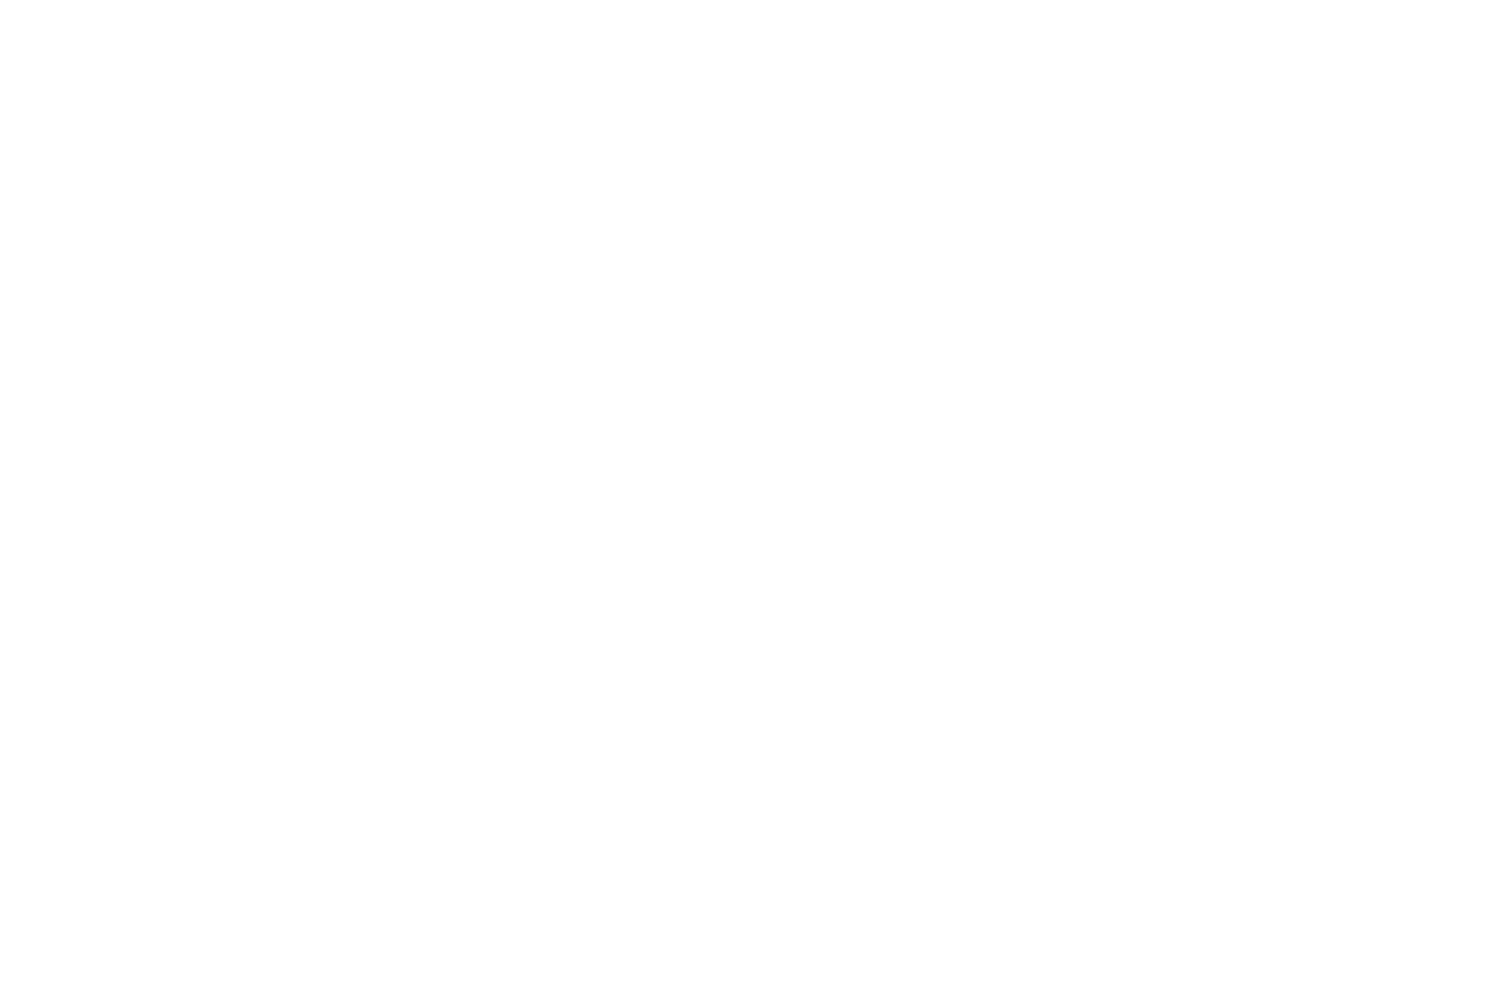

In [8]:
# use matplotlib 2.0
% matplotlib nbagg

Z = q[:,:,1] # Policy for hit. To display policy for stick change 1 to 0
X = np.arange(21)
Y = np.arange(10)
X,Y = np.meshgrid(X,Y)

fig = plt.figure(figsize = (15,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>


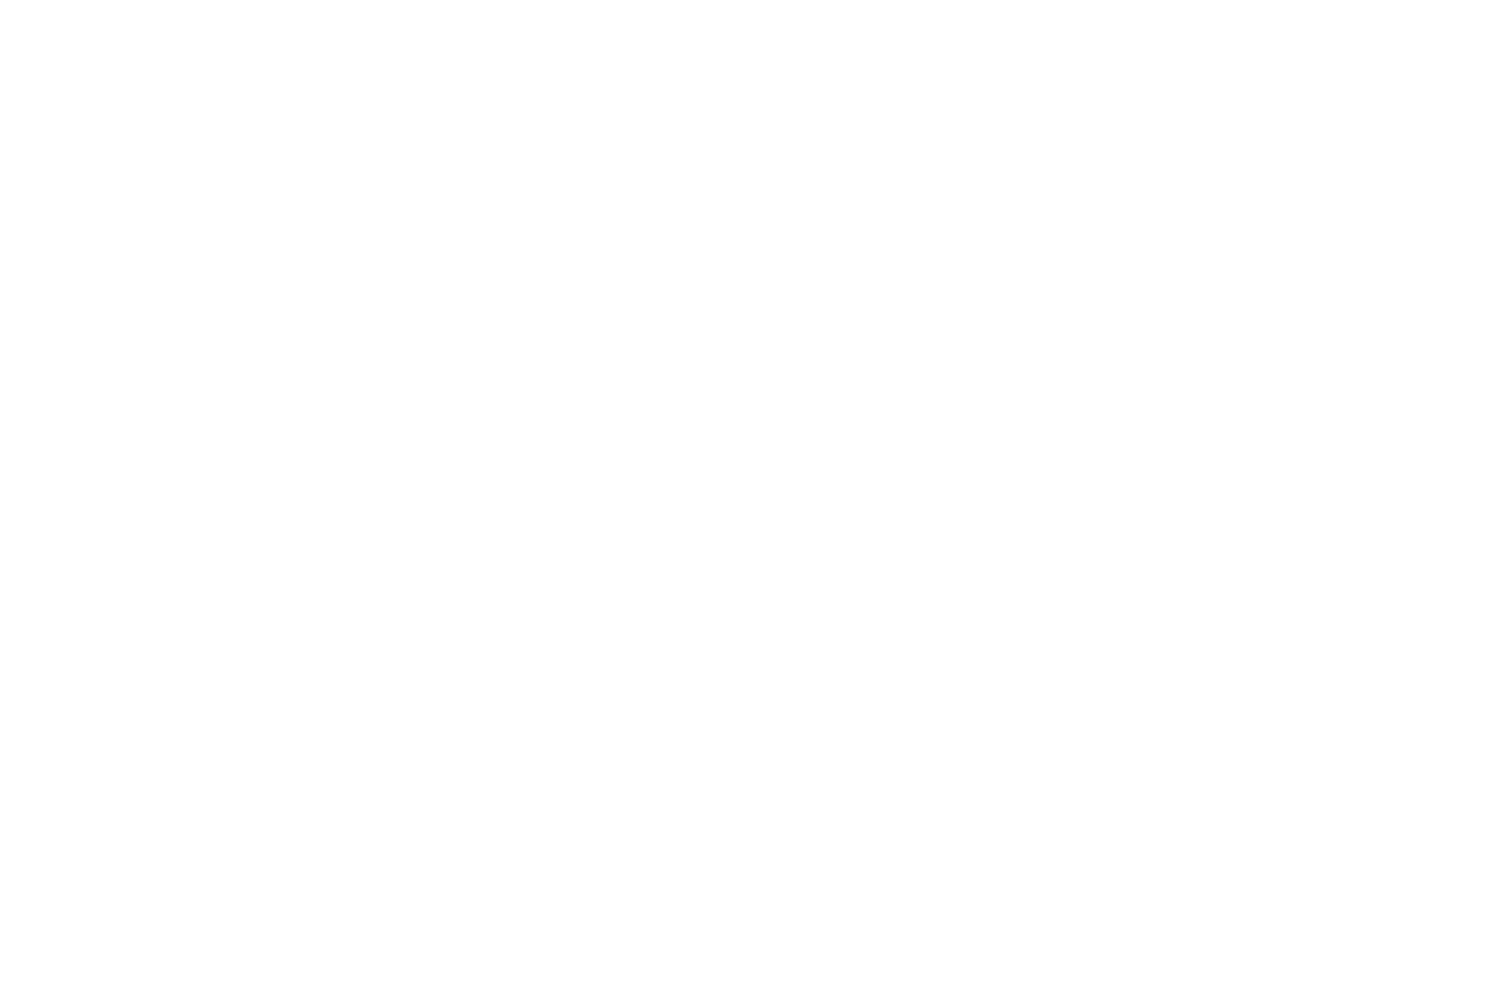

In [9]:
# use matplotlib 2.0
% matplotlib nbagg

Z = q[:,:,0] # Policy for hit. To display policy for stick change 1 to 0
X = np.arange(21)
Y = np.arange(10)
X,Y = np.meshgrid(X,Y)

fig = plt.figure(figsize = (15,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Exploring by playing the game 100000 times

In [20]:
q,n = monteCarlo(100000)

<IPython.core.display.Javascript object>


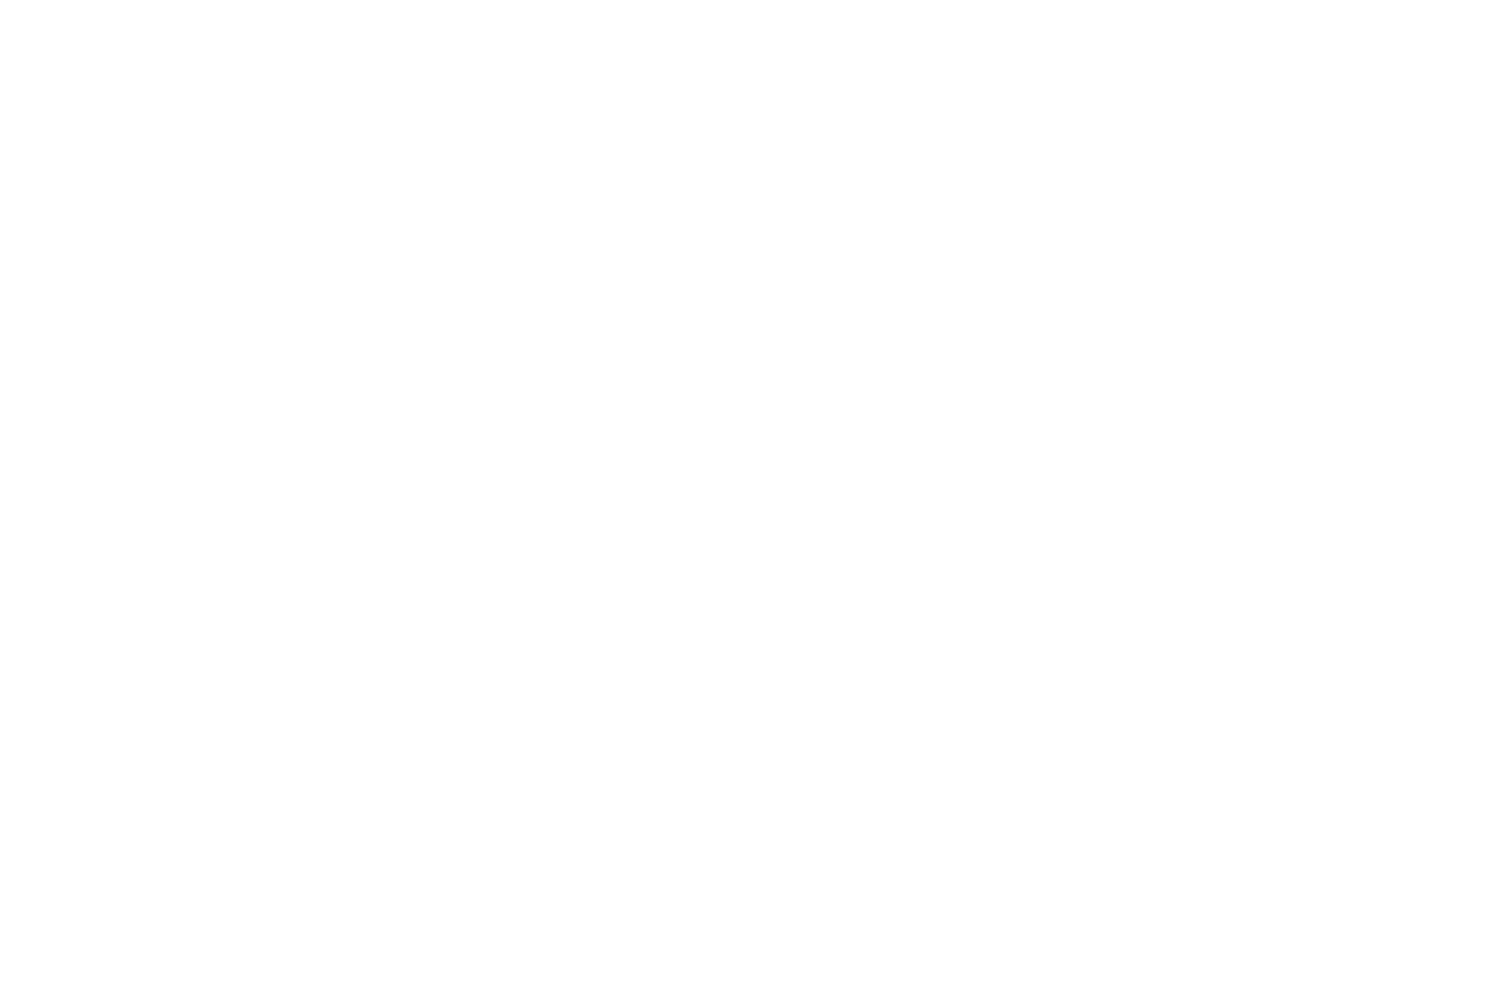

In [11]:
# use matplotlib 2.0
% matplotlib nbagg

Z = q[:,:,1] # Policy for hit. To display policy for stick change 1 to 0
X = np.arange(21)
Y = np.arange(10)
X,Y = np.meshgrid(X,Y)

fig = plt.figure(figsize = (15,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>


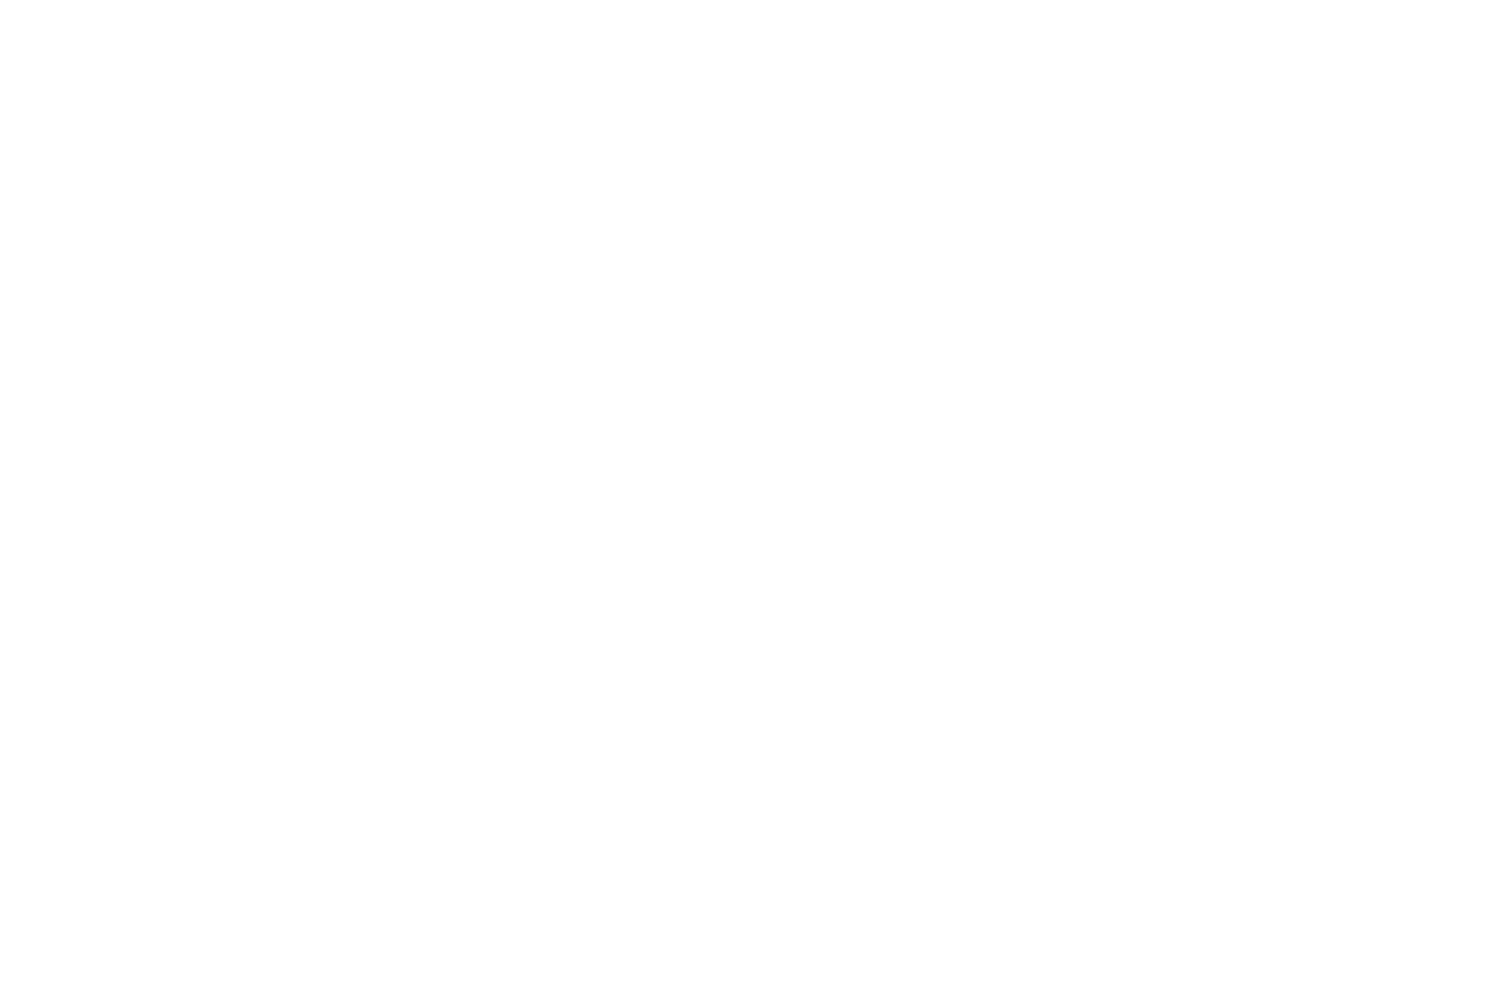

In [12]:
# use matplotlib 2.0
% matplotlib nbagg

Z = q[:,:,0] # Policy for hit. To display policy for stick change 1 to 0
X = np.arange(21)
Y = np.arange(10)
X,Y = np.meshgrid(X,Y)

fig = plt.figure(figsize = (15,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Exploring by playing the game 1000000 times

In [13]:
q,n = monteCarlo(1000000)

<IPython.core.display.Javascript object>


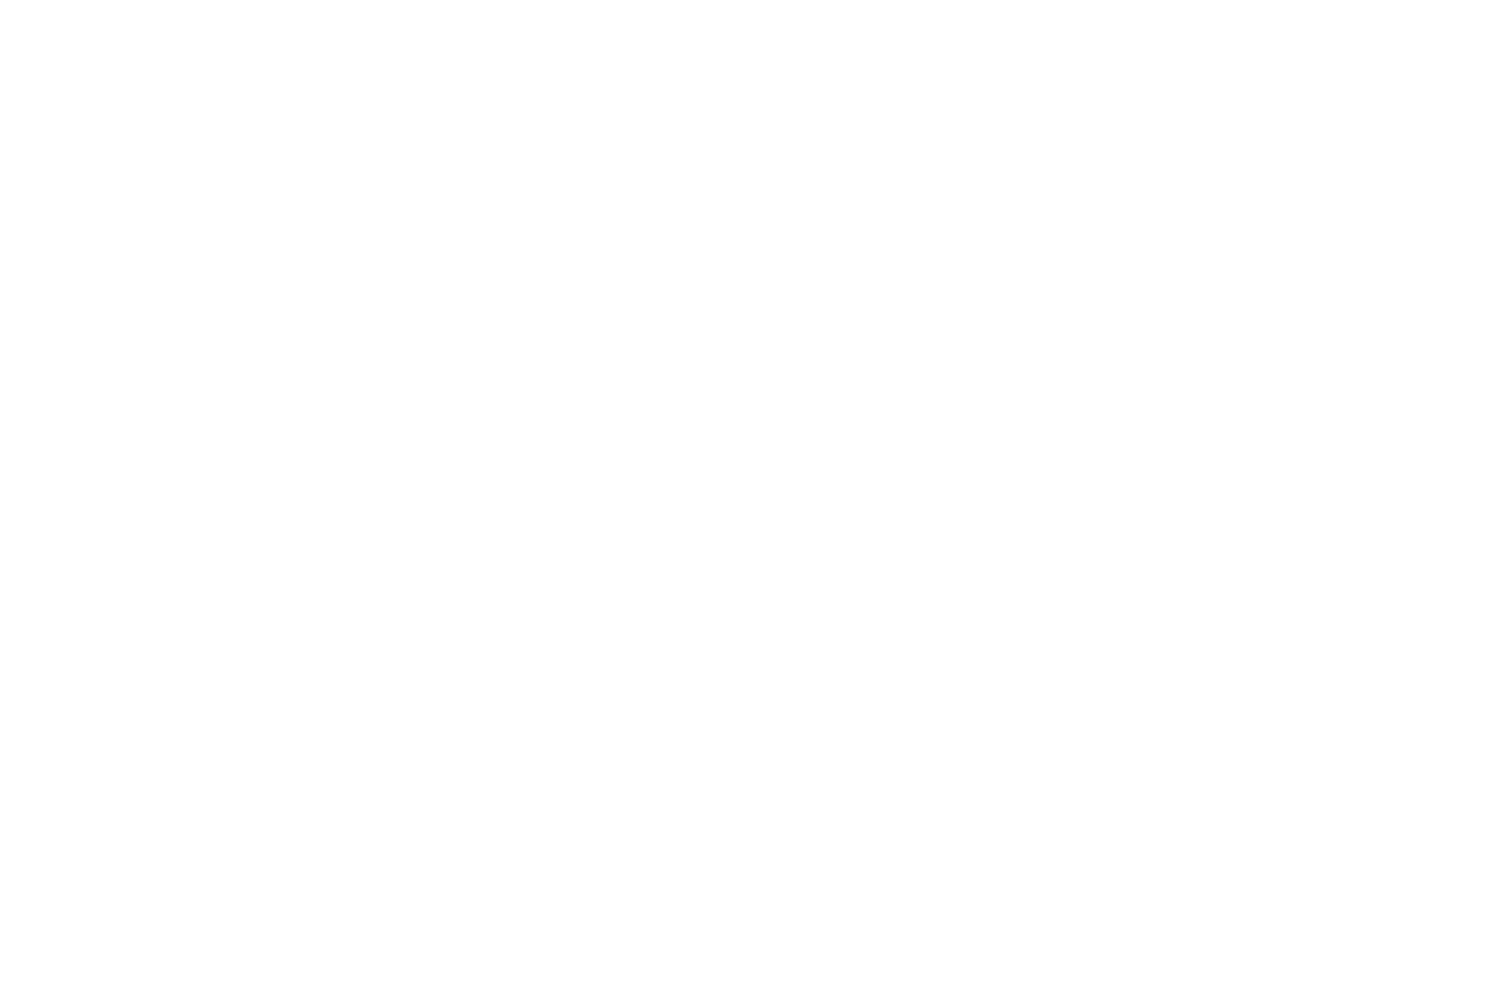

In [14]:
# use matplotlib 2.0
% matplotlib nbagg

Z = q[:,:,1] # Policy for hit. To display policy for stick change 1 to 0
X = np.arange(21)
Y = np.arange(10)
X,Y = np.meshgrid(X,Y)

fig = plt.figure(figsize = (15,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<IPython.core.display.Javascript object>


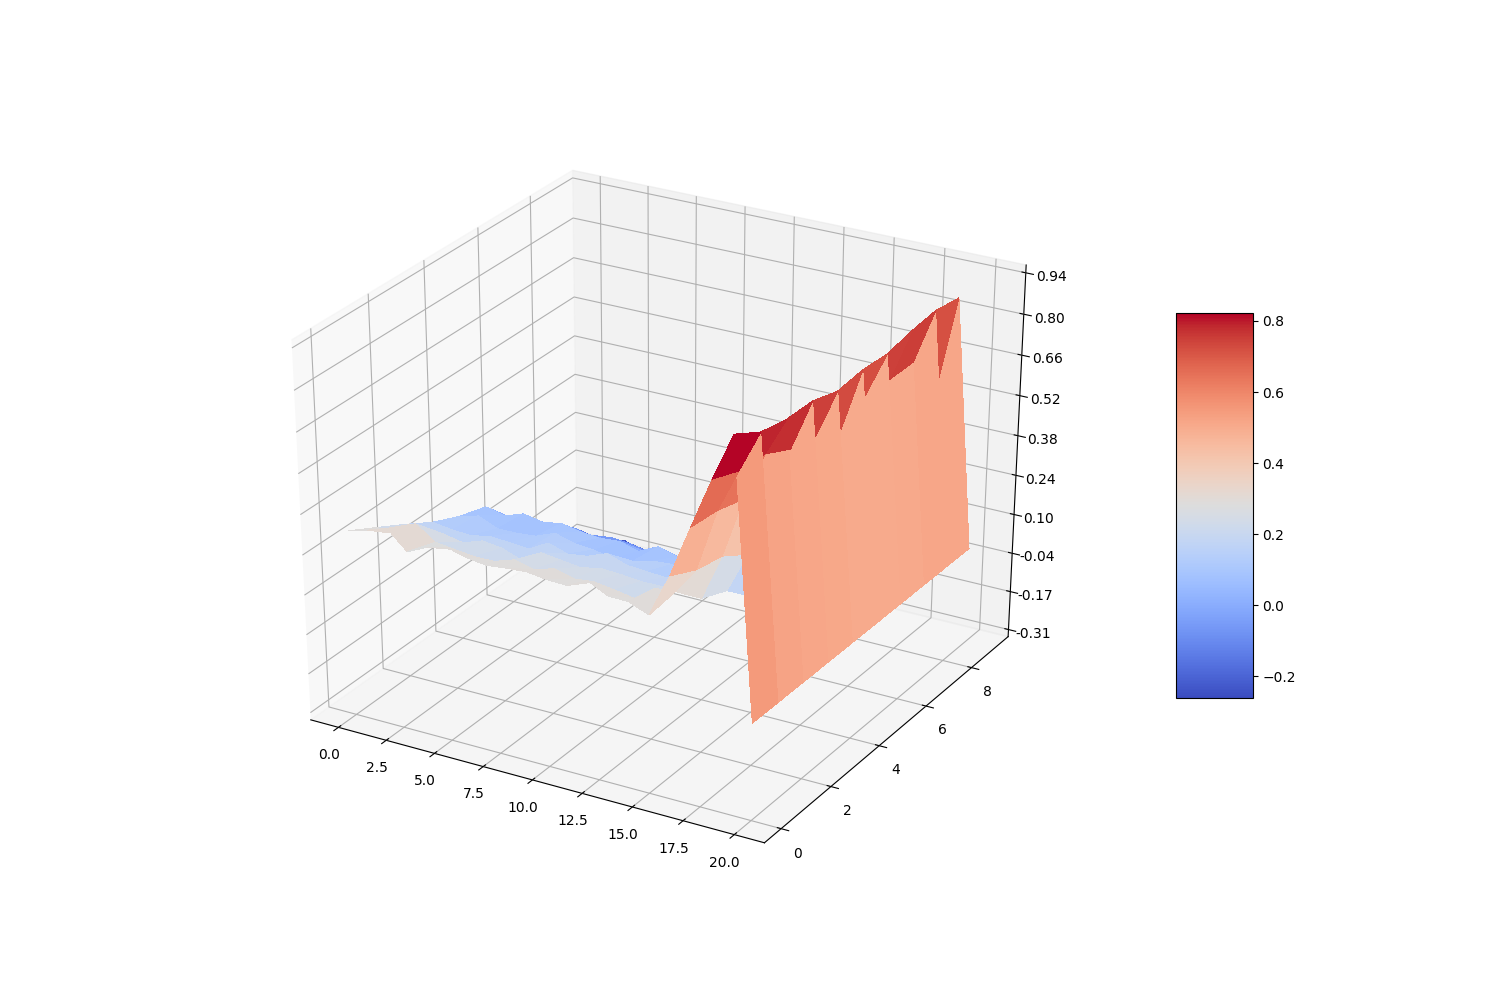

In [15]:
# use matplotlib 2.0
% matplotlib nbagg

Z = q[:,:,0] # Policy for hit. To display policy for stick change 1 to 0
X = np.arange(21)
Y = np.arange(10)
X,Y = np.meshgrid(X,Y)

fig = plt.figure(figsize = (15,10))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

#ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# CONCLUSION

From the diagrams above we can observe that the agent has learnt to stick when the player sum is more towards 21 and hit more at the start when it needs to increase the sum towards 21

## Let's Play


In [16]:
# https://www.youtube.com/watch?v=idB-7FUaC-g
# play with my player's recommendation

In [21]:
with open("q.json","w") as f:
    f.write("data = '"+(json.dumps(q.tolist()))+"'")

In [22]:
v = np.amax(q,2)

In [23]:
with open("v.json","w") as f:
    f.write("data_v = '"+(json.dumps(v.tolist()))+"'")

In [1]:
from IPython.display import Javascript, display_javascript, HTML
from time import sleep

HTML(open("displayCards.html", "r").read())